In [3]:
# Basic Cleaning and Analysis.
# Yiyang Liu Sept 12, 2024
# Data Cleaning and Simple Exploratory Script for the following dataset:
# https://www.kaggle.com/datasets/williamscott701/memotion-dataset-7k


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from PIL import Image
import os, sys
#from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings('ignore')
%matplotlib inline


In [4]:
!pip install transformers


In [5]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
#matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from sklearn.metrics.pairwise import cosine_similarity
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
labelfile = ('/content/labels.csv')
DB = pd.read_csv(labelfile).dropna()
DB = DB.reset_index(drop = True)

In [7]:
import random
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)


In [8]:
DB.to_csv('cleaned_labels.csv', index=False)

In [9]:
DB

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral
...,...,...,...,...,...,...,...,...,...
6825,6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,very_funny,twisted_meaning,very_offensive,motivational,neutral
6826,6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,funny,twisted_meaning,not_offensive,not_motivational,neutral
6827,6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,funny,general,slight,not_motivational,positive
6828,6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,not_funny,twisted_meaning,not_offensive,motivational,very_positive


In [10]:
Sentiments_only = DB[['humour','sarcasm','offensive','motivational','overall_sentiment']]
map_humour = {'hilarious':3, 'very_funny':2, 'funny':1 , 'not_funny':0}
map_sarcasm = {'not_sarcastic':0, 'general':1, 'twisted_meaning':2, 'very_twisted':3}
map_offensive = {'not_offensive':0, 'slight':1, 'very_offensive':2, 'hateful_offensive':3}
map_motivational = {'not_motivational':0, 'motivational': 1}
map_sentiment = {'very_negative': -2, 'negative': -1, 'neutral': 0, 'positive':1, 'very_positive': 2}
# Note: more humorous/sarcastic/offensive = higher score.

Sentiments_only['humour'] = Sentiments_only['humour'].replace(map_humour)
Sentiments_only['sarcasm'] = Sentiments_only['sarcasm'].replace(map_sarcasm)
Sentiments_only['offensive'] = Sentiments_only['offensive'].replace(map_offensive)
Sentiments_only['motivational'] = Sentiments_only['motivational'].replace(map_motivational)
Sentiments_only['overall_sentiment'] = Sentiments_only['overall_sentiment'].replace(map_sentiment)

Sentiments_only

,humour,sarcasm,offensive,motivational,overall_sentiment
0,3,1,0,0,2
1,0,1,0,1,2
2,2,0,0,0,1
3,2,2,2,1,1
4,3,3,2,0,0
...,...,...,...,...,...
6825,2,2,2,1,0
6826,1,2,0,0,0
6827,1,1,1,0,1
6828,0,2,0,1,2


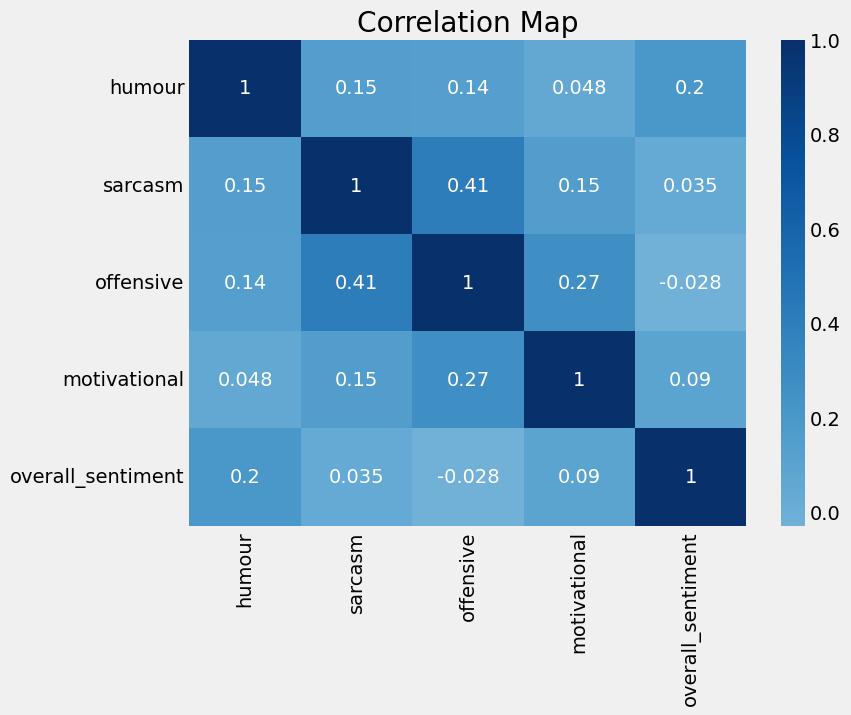

In [11]:
# Correlation between ratings.
S_corr = Sentiments_only.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(S_corr, annot=True, cmap='Blues', center=0)
plt.title('Correlation Map')
plt.show()
# Interpretation? Sarcasm can be offensive. Very intuitive.

In [12]:
# Now work with the Captions/Texts.
import re
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize


def text_to_set_np(row):
    # if we want to exclude the punctuation, but so far let's just use the easy way.
    row = re.sub(r'[^a-zA-Z0-9 ]+','',row)
    #row = re.sub(r'[^a-zA-Z0-9.,!?:; ]+','',row)
    row = row.lower().split()
    return row


def remove_watermark(row):
    patterns = [r".*com.*", r".*net.*", r".*co.*",r".*mobi.*", r".*modi.*", r"meme center", r"memecenter", r"memedroid",r"memetenler",r'avengermemes']
    combined_pattern = re.compile("|".join(patterns))
    for idx in range(len(row)-1,-1,-1):
        if combined_pattern.match(row[idx]):
            row.pop(idx)
    return row

def join_row(row):
    return ' '.join(map(str,row))



TXT_p= pd.DataFrame(DB['text_corrected']).applymap(text_to_set_np)
TXT_p = TXT_p.applymap(remove_watermark) #with punctuation
TXT_p = TXT_p.applymap(join_row)


#TXT_np= pd.DataFrame(DB['text_corrected']).applymap(text_to_set_np)
#TXT_np = TXT_np.applymap(remove_watermark) #without punctuation

print(TXT_p)
# Notes
# Several things to take care of:
# 1) get rid of all the special characters. (done)
# 2) site names like memegenerator.com (done)
# 3) Tentatively: Use word2vec(CBOW)/CoVe/BERT




                                         text_corrected
0     look there my friend lightyear now all sohalik...
1     the best of 10 yearchallenge in less the 4 yea...
2     sam thorne strippin follow follow saw everyone...
3                   10 year challenge sweet dee edition
4     10 year challenge with no filter 47 hilarious ...
...                                                 ...
6825  tuesday is mardi gras wednesday is valentines ...
6826  must watch movies of 2017 iti chennai memes ma...
6827  less more talking planning soda junk food worr...
6828  when i have time is a fantasy no one has time ...
6829  the starting point for every good idea is what...

[6830 rows x 1 columns]


In [13]:
from sklearn.model_selection import train_test_split

# Assuming 'text_corrected' is the column you want to use
train_texts, test_texts, train_labels, test_labels = train_test_split(
    DB['text_corrected'].tolist(),  # Change 'text' to 'text_corrected'
    DB['overall_sentiment'].tolist(),  # Assuming 'overall_sentiment' is your label
    test_size=0.2,
    random_state=42
)

In [14]:
# Input text
text = DB['text_corrected']

In [15]:
text

,text_corrected
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...
1,The best of #10 YearChallenge! Completed in le...
2,Sam Thorne @Strippin ( Follow Follow Saw every...
3,10 Year Challenge - Sweet Dee Edition
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...
...,...
6825,Tuesday is Mardi Gras Wednesday is Valentine's...
6826,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...
6827,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...
6828,When I have time is a fantasy. no one has time...


In [16]:
# Input text
text = DB['text_corrected'].tolist()  # Convert the column to a list of strings

# Tokenize and encode text using batch_encode_plus
# The function returns a dictionary containing the token IDs and attention masks
encoding = tokenizer.batch_encode_plus(
    text,                     # List of input texts
    padding=True,             # Pad to the maximum sequence length
    truncation=True,          # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True   # Add special tokens CLS and SEP
)

input_ids = encoding['input_ids']  # Token IDs
# Print input IDs
print(f"Input IDs: {input_ids}")

attention_mask = encoding['attention_mask']  # Attention mask
# Print attention mask
print(f"Attention mask: {attention_mask}")

Input IDs: tensor([[  101,  2298,  2045,  ...,     0,     0,     0],
        [  101,  1996,  2190,  ...,     0,     0,     0],
        [  101,  3520, 14296,  ...,     0,     0,     0],
        ...,
        [  101,  2625,  2062,  ...,     0,     0,     0],
        [  101,  2043,  1045,  ...,     0,     0,     0],
        [  101,  1996,  3225,  ...,     0,     0,     0]])
Attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [22]:

# Generate embeddings using BERT model
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    word_embeddings = outputs.last_hidden_state  # This contains the embeddings

# Output the shape of word embeddings
print(f"Shape of Word Embeddings: {word_embeddings.shape}")


Shape of Word Embeddings: torch.Size([6830, 261, 768])


In [23]:

# Decode the token IDs back to text
decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
#print decoded text
print(f"Decoded Text: {decoded_text}")
# Tokenize the text again for reference
tokenized_text = tokenizer.tokenize(decoded_text)
#print tokenized text
print(f"tokenized Text: {tokenized_text}")
# Encode the text
encoded_text = tokenizer.encode(text, return_tensors='pt')  # Returns a tensor
# Print encoded text
print(f"Encoded Text: {encoded_text}")


Decoded Text: look there my friend lightyear now all sohalikut trend play the 10 years challenge at facebook imgflip. com
tokenized Text: ['look', 'there', 'my', 'friend', 'light', '##year', 'now', 'all', 'so', '##hal', '##ik', '##ut', 'trend', 'play', 'the', '10', 'years', 'challenge', 'at', 'facebook', 'im', '##gf', '##lip', '.', 'com']
Encoded Text: tensor([[101, 100, 100,  ..., 100, 100, 102]])


In [24]:

# Print word embeddings for each token
for token, embedding in zip(tokenized_text, word_embeddings[0]):
    #print(f"Token: {token}")
    print(f"Embedding: {embedding}")
    print("\n")


Embedding: tensor([ 1.0958e-01, -1.2100e-01,  1.7062e-01,  1.1445e-01, -5.0750e-01,
        -4.7446e-01,  3.4685e-01,  6.7484e-01, -1.9297e-01, -1.1321e-01,
        -1.7239e-02,  8.1985e-02,  5.4787e-02,  5.2823e-01,  4.7345e-01,
        -1.4174e-02, -4.5327e-01,  6.2097e-01,  2.2616e-01,  1.3785e-01,
         1.4825e-01, -7.2082e-01,  1.7497e-01, -2.4553e-02,  1.9292e-01,
         1.3450e-01,  4.6563e-02, -1.9008e-01,  2.5214e-02, -3.6922e-02,
         6.3350e-03,  1.1500e-01, -4.4844e-02, -1.2156e-01,  4.8571e-01,
        -2.3896e-01,  2.2355e-01, -3.3901e-01,  2.5620e-01,  3.4109e-01,
        -2.0196e-01,  3.4010e-03, -1.5230e-02, -1.7121e-02, -7.5147e-02,
        -1.4690e-01, -3.1267e+00,  1.2097e-01, -2.5476e-01, -2.6646e-01,
         3.1544e-01, -2.0229e-01,  1.4809e-01,  4.7018e-02,  1.7525e-01,
         5.6151e-01, -2.6432e-01,  7.2180e-01,  7.1623e-02,  3.3129e-01,
        -4.8395e-02,  3.0880e-01, -1.4636e-01,  1.0778e-01, -3.2089e-01,
         2.7033e-01,  1.4348e-01,  4.574

In [27]:

# Compute the average of word embeddings to get the sentence embedding
sentence_embedding = word_embeddings.mean(dim=1)  # Average pooling along the sequence length dimension

# Print the sentence embedding
print("Sentence Embedding:")
print(sentence_embedding)

# Output the shape of the sentence embedding
print(f"Shape of Sentence Embedding: {sentence_embedding.shape}")


Sentence Embedding:
tensor([[ 0.0348, -0.2186,  0.5091,  ...,  0.0613, -0.0951, -0.0495],
        [-0.2523, -0.3497,  0.4445,  ...,  0.0072,  0.2561,  0.0483],
        [ 0.1243, -0.0565,  0.6747,  ...,  0.0435,  0.2394,  0.0683],
        ...,
        [ 0.3569,  0.0417,  0.2815,  ..., -0.1839, -0.0787, -0.1191],
        [ 0.2929, -0.1947,  0.3552,  ..., -0.1465, -0.0009, -0.0747],
        [ 0.1683, -0.2587,  0.3160,  ...,  0.0710,  0.1017, -0.0235]])
Shape of Sentence Embedding: torch.Size([6830, 768])


In [30]:
import torch.nn.functional as F

# Assuming sentence_embeddings is a tensor of shape (n_sentences, embedding_dim)
# where n_sentences is the number of sentences and embedding_dim is the size of each embedding.
# For example, sentence_embeddings might be of shape (100, 768) if you have 100 sentences
# and each embedding has 768 dimensions.

# Normalize the sentence embeddings to unit vectors
normalized_embedding = F.normalize(sentence_embedding, p=2, dim=1)

# Compute cosine similarity between all pairs
cosine_sim_matrix = torch.mm(normalized_embedding, normalized_embedding.T)

# Output the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)


Cosine Similarity Matrix:
tensor([[1.0000, 0.8307, 0.8617,  ..., 0.7855, 0.9093, 0.8751],
        [0.8307, 1.0000, 0.8334,  ..., 0.7162, 0.7874, 0.7510],
        [0.8617, 0.8334, 1.0000,  ..., 0.7514, 0.8174, 0.7836],
        ...,
        [0.7855, 0.7162, 0.7514,  ..., 1.0000, 0.7688, 0.7227],
        [0.9093, 0.7874, 0.8174,  ..., 0.7688, 1.0000, 0.9052],
        [0.8751, 0.7510, 0.7836,  ..., 0.7227, 0.9052, 1.0000]])


In [32]:
import pandas as pd

# Assuming cosine_sim_matrix is your cosine similarity matrix
# Convert the tensor to a NumPy array
cosine_sim_matrix_np = cosine_sim_matrix.numpy()

# Create a Pandas DataFrame from the NumPy array
cosine_sim_df = pd.DataFrame(cosine_sim_matrix_np)

# Optionally, you can add row and column labels
# For example, if you have a list of sentence IDs or labels:
# sentence_labels = ["sentence_1", "sentence_2", ..., "sentence_n"]
# cosine_sim_df.columns = sentence_labels
# cosine_sim_df.index = sentence_labels

# Export the DataFrame to a CSV file
cosine_sim_df.to_csv("cosine_similarity_matrix.csv", index=False)

print("Cosine similarity matrix exported to 'cosine_similarity_matrix.csv'")

Cosine similarity matrix exported to 'cosine_similarity_matrix.csv'


In [31]:
print(DB.head)

<bound method NDFrame.head of       Unnamed: 0      image_name  \
0              0     image_1.jpg   
1              1    image_2.jpeg   
2              2     image_3.JPG   
3              3     image_4.png   
4              4     image_5.png   
...          ...             ...   
6825        6987  image_6988.jpg   
6826        6988  image_6989.jpg   
6827        6989  image_6990.png   
6828        6990  image_6991.jpg   
6829        6991  image_6992.jpg   

                                               text_ocr  \
0     LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1     The best of #10 YearChallenge! Completed in le...   
2     Sam Thorne @Strippin ( Follow Follow Saw every...   
3                 10 Year Challenge - Sweet Dee Edition   
4     10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   
...                                                 ...   
6825  Tuesday is Mardi Gras Wednesday is Valentine's...   
6826  MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...   
6827  

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:


#create a filter for the entries
criterion0 = Sentiments_only['overall_sentiment']  >= -3
criterion1 = Sentiments_only['offensive']  >=0
criterion2 = Sentiments_only['sarcasm'] >=0
criterion3 = Sentiments_only['motivational'] > -1
criterion4 = Sentiments_only['humour'] >= 0

criteria = criterion0 & criterion1 & criterion2 & criterion3 & criterion4

idx = Sentiments_only.index[criteria].tolist()

all_words_str = ''
for i in idx:
    #print(TXT_np.loc[i].values)
    words = ' '.join(map(str,TXT_word.loc[i].values[0]))
    all_words_str += words + ' '




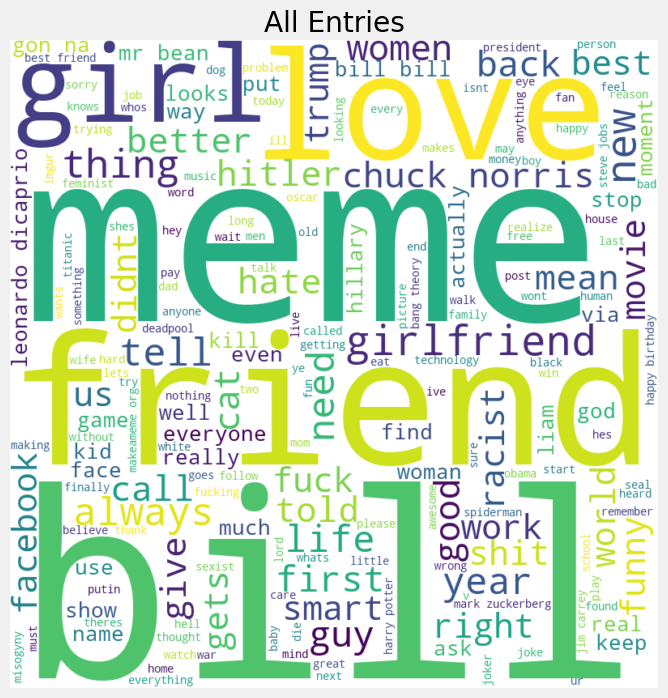

In [ ]:
# Display the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(WC, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('All Entries')
plt.show()


#bill memes: This is bill. Bill is....
#Many memes about memes.
#Friend. Girlfriend. Girl.
#trump hitler chuck norris who else?

In [ ]:
# Making all the images the same size.

from PIL import Image
import os, sys

path = ('type the path to the images here')

def resize_image():
for item in os.listdir(path):
    if os.path.isfile(item):
        im = Image.open(item)
        f, e = os.path.splitext(item)
        imResize = im.resize((200,200), Image.ANTIALIAS)
        imResize.save(f + ' resized.jpg', 'JPEG', quality=90)